In [2]:
import os
import torch
import pathlib
import cv2
import easyocr
import numpy as np
from IPython.display import display, clear_output
from PIL import Image

In [3]:
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

In [4]:
# Load the YOLOv5 model from your saved weights
model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5_trained_model/weights/best.pt') 

Using cache found in C:\Users\saaji/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-10-4 Python-3.11.0 torch-2.4.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [5]:
# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])  # Specify the languages you want to use

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


### Image

In [6]:
# Function to process the image
def process_image(image_path):
    # Open the image using PIL
    image = Image.open(image_path).convert("RGB")  # Ensure the image is in RGB mode

    # Convert the uploaded image to a format OpenCV can use
    frame = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # Perform inference with YOLO
    results = model(frame)
    predictions = results.xyxy[0]  # Get predictions

    # Loop through each detected bounding box
    for *box, conf, cls in predictions:
        x1, y1, x2, y2 = map(int, box)  # Convert to integers

        # Crop the region of interest for OCR
        roi = frame[y1:y2, x1:x2]

        # Use EasyOCR to perform text recognition on the ROI
        ocr_results = reader.readtext(roi)
        
        # Draw a single bounding box around the license plate
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green box around the entire plate

        # Draw bounding box and detected text
        for (bbox, text, prob) in ocr_results:
            (top_left, top_right, bottom_right, bottom_left) = bbox
            top_left = tuple(map(int, top_left))
            bottom_right = tuple(map(int, bottom_right))

            # Adjust the coordinates of the detected text back to the original frame
            adjusted_top_left = (top_left[0] + x1, top_left[1] + y1)
            adjusted_bottom_right = (bottom_right[0] + x1, bottom_right[1] + y1)

            
            # Increase font scale and thickness for better visibility
            font_scale = 0.8  # Increase font size
            thickness = 2  # Increase thickness for better visibility
            

            # Put the detected text on the frame
            cv2.putText(frame, text, (adjusted_top_left[0], adjusted_top_left[1] - 15), 
                        cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 0), thickness)

    # Convert the frame to RGB for display
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Display the processed frame
    clear_output(wait=True)  # Clear previous output
    display(Image.fromarray(frame_rgb))  # Display the frame

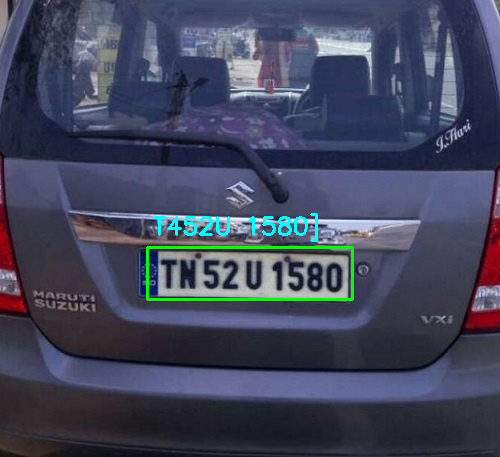

In [21]:
# Hardcoded image path
image_path = 'TEST/Test_1.jpeg'  # Replace with your image file path

# Process the image
process_image(image_path)

### Video

In [22]:
def process_video(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    frame_skip = 2  # Process every 2nd frame
    frame_count = 0  # Frame counter

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Skip frames to reduce load
        if frame_count % frame_skip != 0:
            frame_count += 1
            continue


        # Perform inference with YOLO
        results = model(frame)
        predictions = results.xyxy[0]  # Get predictions

        # Loop through each detected bounding box
        for *box, conf, cls in predictions:
            x1, y1, x2, y2 = map(int, box)  # Convert to integers

            # Crop the region of interest for OCR
            roi = frame[y1:y2, x1:x2]

            # Use EasyOCR to perform text recognition
            ocr_results = reader.readtext(roi)

            # Draw bounding box and detected text
            for (bbox, text, prob) in ocr_results:
            # Draw bounding box and text
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Blue box
                cv2.putText(frame, text.upper(), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)  # Blue text

        # Display the processed frame
        clear_output(wait=True)  # Clear previous output
        display(Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))  # Display the frame

        frame_count += 1  # Increment frame counter

    cap.release()

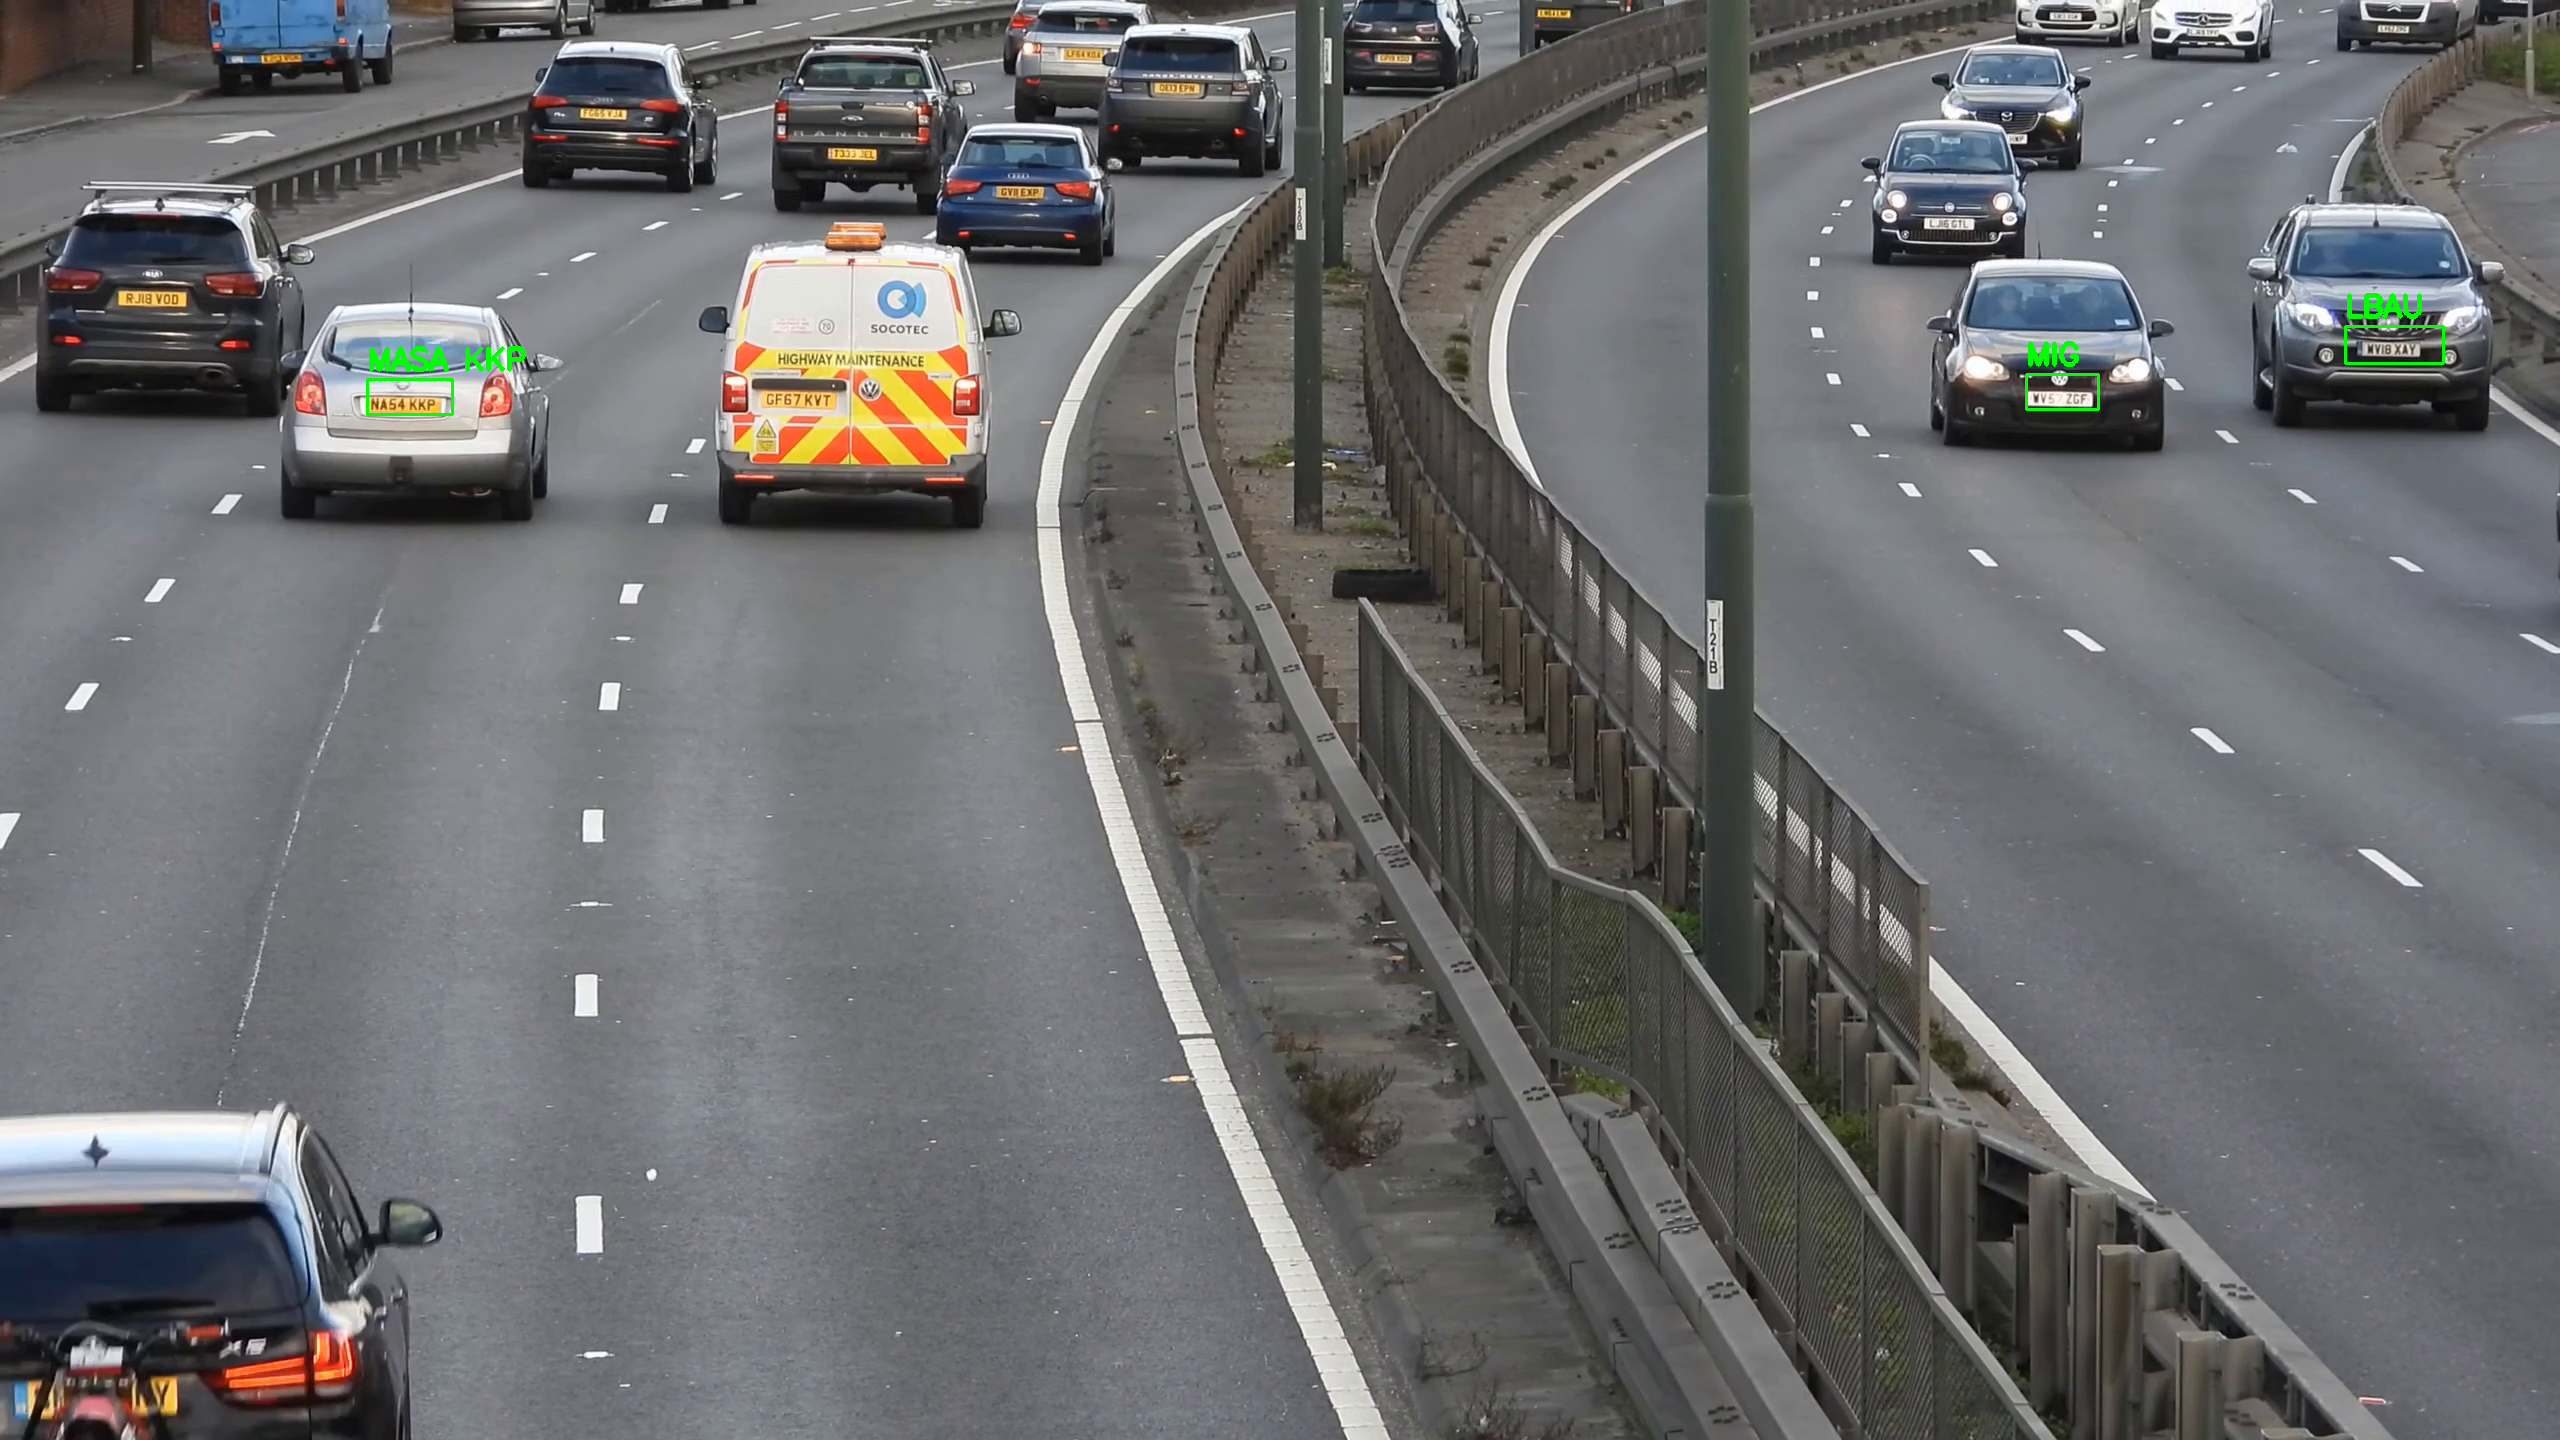

In [23]:
video_path = 'TEST/TEST_V.mp4'  # Adjust the path to where your video is located
process_video(video_path)